# Catch that asteroid!

<div class="alert alert-warning">This code requires a development version of astropy, which can be installed like this:

<code>pip install https://github.com/Juanlu001/astropy/archive/ecliptic-precision.zip</code>

As soon as these changes are merged and released we will update these instructions.
</div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter, plot

EPOCH = Time("2017-09-01 12:05:50", scale="tdb")

In [2]:
earth = Orbit.from_body_ephem(Earth, EPOCH)
earth

1 x 1 AU x 23.4 deg orbit around Sun (☉)

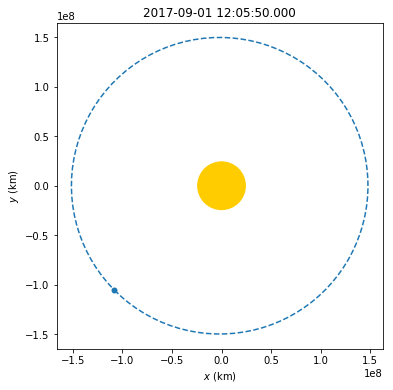

In [3]:
plot(earth)

In [4]:
from poliastro.neos import neows

In [5]:
florence = neows.orbit_from_name("Florence")
florence

1 x 3 AU x 22.2 deg orbit around Sun (☉)

Two problems: the epoch is not the one we desire, and the inclination is with respect to the ecliptic!

In [6]:
florence.epoch

<Time object: scale='tdb' format='jd' value=2458000.5>

In [7]:
florence.epoch.iso

'2017-09-04 00:00:00.000'

In [8]:
florence.inc

<Quantity 22.15077690996863 deg>

We first propagate:

In [9]:
florence = florence.propagate(EPOCH - florence.epoch)
florence.epoch.tdb.iso

'2017-09-01 12:05:50.000'

And now we have to another reference frame.

In [10]:
from astropy.coordinates import (
    ICRS, GCRS, HeliocentricTrueEcliptic,
    CartesianRepresentation, CartesianDifferential
)

In [11]:
florence_hte = HeliocentricTrueEcliptic(
    x=florence.r[0], y=florence.r[1], z=florence.r[2],
    d_x=florence.v[0], d_y=florence.v[1], d_z=florence.v[2],
    representation=CartesianRepresentation,
    differential_cls=CartesianDifferential,
    obstime=EPOCH
)
florence_hte

<HeliocentricTrueEcliptic Coordinate (equinox=J2000.000, obstime=2017-09-01 12:05:50.000): (x, y, z) in km
    (  1.45904366e+08, -58569290.90352102,  2270779.28287384)
 (d_x, d_y, d_z) in km / s
    ( 7.408196,  31.11060243,  12.80050188)>

In [12]:
florence_icrs_trans = florence_hte.transform_to(ICRS)
florence_icrs_trans.representation = CartesianRepresentation
florence_icrs_trans

<ICRS Coordinate: (x, y, z) in km
    (  1.46271267e+08, -53880021.57049114, -20906906.94345007)
 (v_x, v_y, v_z) in km / s
    ( 7.40819573,  23.45167602,  24.11931441)>

In [13]:
florence_icrs = Orbit.from_vectors(
    Sun,
    r=[florence_icrs_trans.x, florence_icrs_trans.y, florence_icrs_trans.z] * u.km,
    v=[florence_icrs_trans.v_x, florence_icrs_trans.v_y, florence_icrs_trans.v_z] * (u.km / u.s),
    epoch=florence.epoch
)
florence_icrs

1 x 3 AU x 44.6 deg orbit around Sun (☉)

In [14]:
florence_icrs.rv()

(<Quantity [  1.46271267e+08, -5.38800216e+07, -2.09069069e+07] km>,
 <Quantity [  7.40819573, 23.45167602, 24.11931441] km / s>)

Let us compute the distance between Florence and the Earth:

In [15]:
from poliastro.util import norm

In [16]:
norm(florence_icrs.r - earth.r) - Earth.R

<Quantity 7060323.245127451 km>

<div class="alert alert-success">This value is consistent with what ESA says! $7\,060\,160$ km</div>

In [17]:
from IPython.display import HTML

HTML(
"""<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">La <a href="https://twitter.com/esa_es">@esa_es</a> ha preparado un resumen del asteroide <a href="https://twitter.com/hashtag/Florence?src=hash">#Florence</a> 😍 <a href="https://t.co/Sk1lb7Kz0j">pic.twitter.com/Sk1lb7Kz0j</a></p>&mdash; AeroPython (@AeroPython) <a href="https://twitter.com/AeroPython/status/903197147914543105">August 31, 2017</a></blockquote>
<script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>"""
)

And now we can plot!

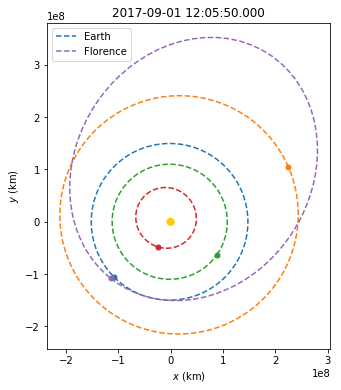

In [18]:
frame = OrbitPlotter()

frame.plot(earth, label="Earth")

frame.plot(Orbit.from_body_ephem(Mars, EPOCH))
frame.plot(Orbit.from_body_ephem(Venus, EPOCH))
frame.plot(Orbit.from_body_ephem(Mercury, EPOCH))

frame.plot(florence_icrs, label="Florence")

The difference between doing it well and doing it wrong is clearly visible:

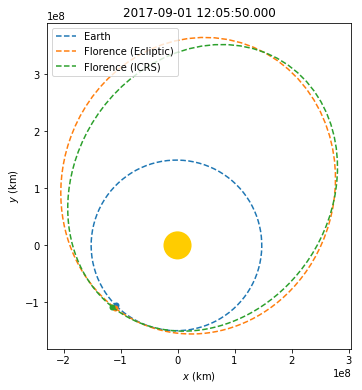

In [19]:
frame = OrbitPlotter()

frame.plot(earth, label="Earth")

frame.plot(florence, label="Florence (Ecliptic)")
frame.plot(florence_icrs, label="Florence (ICRS)")

And now let's do something more complicated: express our orbit with respect to the Earth!

In [20]:
florence_gcrs_trans = florence_hte.transform_to(GCRS(obstime=EPOCH))
florence_gcrs_trans.representation = CartesianRepresentation
florence_gcrs_trans

<GCRS Coordinate (obstime=2017-09-01 12:05:50.000, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (x, y, z) in km
    ( 4966317.40345486, -5018488.03674859,  297888.72362275)
 (v_x, v_y, v_z) in km / s
    (-2.76032188, -1.96905254,  13.09870055)>

In [21]:
florence_hyper = Orbit.from_vectors(
    Earth,
    r=[florence_gcrs_trans.x, florence_gcrs_trans.y, florence_gcrs_trans.z] * u.km,
    v=[florence_gcrs_trans.v_x, florence_gcrs_trans.v_y, florence_gcrs_trans.v_z] * (u.km / u.s),
    epoch=EPOCH
)
florence_hyper

7066699 x -7071056 km x 104.3 deg orbit around Earth (♁)

Notice that the ephemerides of the Moon is also given in ICRS!

In [22]:
moon = Orbit.from_body_ephem(Moon, EPOCH)
moon

151218466 x -151219347 km x 23.3 deg orbit around Earth (♁)

In [23]:
moon.a

<Quantity -440.4213076106402 km>

In [24]:
moon.ecc

<Quantity 343350.5680364506>

So we have to convert again.

In [25]:
moon_icrs = ICRS(
    x=moon.r[0], y=moon.r[1], z=moon.r[2],
    v_x=moon.v[0], v_y=moon.v[1], v_z=moon.v[2],
    representation=CartesianRepresentation,
    differential_cls=CartesianDifferential
)
moon_icrs

<ICRS Coordinate: (x, y, z) in km
    (  1.41399531e+08, -49228391.42507221, -21337616.62766309)
 (v_x, v_y, v_z) in km / s
    ( 11.10890252,  25.6785744,  11.0567569)>

Important to use the `obstime` attribute of `GCRS`, otherwise the system does not know where the Earth is.

In [26]:
moon_gcrs = moon_icrs.transform_to(GCRS(obstime=EPOCH))
moon_gcrs.representation = CartesianRepresentation
moon_gcrs

<GCRS Coordinate (obstime=2017-09-01 12:05:50.000, obsgeoloc=( 0.,  0.,  0.) m, obsgeovel=( 0.,  0.,  0.) m / s): (x, y, z) in km
    ( 94189.90120828, -367278.24304992, -133087.21297573)
 (v_x, v_y, v_z) in km / s
    ( 0.94073662,  0.25786326,  0.03569047)>

In [27]:
moon = Orbit.from_vectors(
    Earth,
    [moon_gcrs.x, moon_gcrs.y, moon_gcrs.z] * u.km,
    [moon_gcrs.v_x, moon_gcrs.v_y, moon_gcrs.v_z] * (u.km / u.s),
    epoch=EPOCH
)
moon

367937 x 405209 km x 19.4 deg orbit around Earth (♁)

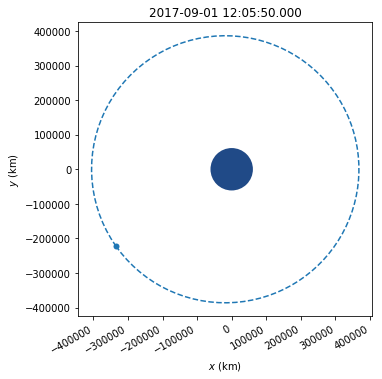

In [30]:
plot(moon)
plt.gcf().autofmt_xdate()

And now for the final plot:

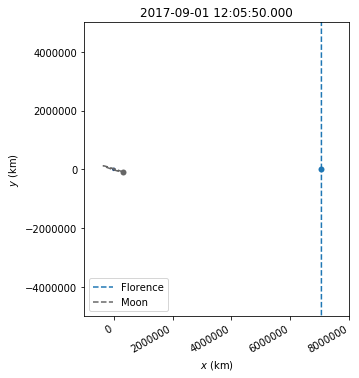

In [29]:
frame = OrbitPlotter()

frame.plot(florence_hyper, label="Florence")
l_moon = frame.plot(moon, label="Moon")

[l.set_color("#666666") for l in l_moon]

plt.xlim(-1000000, 8000000)
plt.ylim(-5000000, 5000000)

plt.legend()
plt.gcf().autofmt_xdate()

<div style="text-align: center; font-size: 3em;"><em>Per Python ad astra!</em></div>